In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', font_scale=1.5)
%matplotlib inline

from scipy.io import loadmat
from scipy.io import netcdf

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Вспышка 10.06.2014

## Данные

In [3]:
from os import listdir

In [4]:
path = './data_gnss_2014_06_10/'

files = listdir(path)
df_list = []
for file in files:
    data = loadmat(path + file)
    matr_gps = pd.DataFrame(data['Matr_GPS'])
    df_list.append(matr_gps)

In [5]:
m = pd.concat(df_list)
m.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,27442.0,3.0,-1.144173e+07,1.097274e+07,2.074410e+07,0.0,18.0,-0.000138,2.272598e+07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27442.0,5.0,2.379554e+07,-3.570731e+06,1.139150e+07,0.0,18.0,-0.000138,2.262436e+07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27442.0,19.0,-1.014783e+07,1.492520e+07,1.918178e+07,0.0,18.0,-0.000138,2.304302e+07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,27442.0,30.0,9.340308e+06,1.214081e+07,2.168677e+07,0.0,18.0,-0.000138,2.024329e+07,NaN,...,NaN,79439102.35,NaN,NaN,-478.977,NaN,NaN,NaN,NaN,NaN
4,27442.0,7.0,4.162750e+05,1.850906e+07,1.898161e+07,0.0,18.0,-0.000138,2.131254e+07,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
param_gps = data['Param_GPS']

for attribute in param_gps[0]:
    print('\"' + attribute[0] + '\"', end=', ')

"Time", "PRN", "X ECEF", "Y ECEF", "Z ECEF", "Flag", "N S", "Clock ofset", "C1C", "L", "S/N", "L1C", "L", "S/N", "D1C", "L", "S/N", "S1C", "L", "S/N", "C1W", "L", "S/N", "L1W", "L", "S/N", "S1W", "L", "S/N", "C2X", "L", "S/N", "L2X", "L", "S/N", "D2X", "L", "S/N", "S2X", "L", "S/N", "C2W", "L", "S/N", "L2W", "L", "S/N", "D2W", "L", "S/N", "S2W", "L", "S/N", "C5X", "L", "S/N", "L5X", "L", "S/N", "D5X", "L", "S/N", "S5X", "L", "S/N", 

In [7]:
n_x = np.where(param_gps[0] == 'X ECEF')[0][0]
n_y = np.where(param_gps[0] == 'Y ECEF')[0][0]
n_z = np.where(param_gps[0] == 'Z ECEF')[0][0]
n_x, n_y, n_z

(2, 3, 4)

In [8]:
position = np.array([data['Position_X'][0][0], data['Position_Y'][0][0], data['Position_Z'][0][0]])
x_p, y_p, z_p = position
x_p, y_p, z_p

(2901500.5761, 2247914.8617, 5198949.1083)

In [9]:
x_s = m.values[:, n_x]
y_s = m.values[:, n_y]
z_s = m.values[:, n_z]

## Фазовые измерения

### Расчет угла между спутником и приемником

In [10]:
import pymap3d as pm

https://geospace-code.github.io/pymap3d/

In [11]:
lat, lon, alt = pm.ecef2geodetic(x_p, y_p, z_p, ell=None, deg=False)
lon, lat, alt

(0.6591489693583588, 0.9592235023771303, 190.0168260222466)

In [12]:
az, elev, slantRange = pm.ecef2aer(x_s, y_s, z_s, lat, lon, alt, ell=None, deg=False)
elev

array([0.41788559, 0.58777309, 0.45013033, ..., 0.34783319, 0.92720085,
       1.15310165])

In [13]:
cos_a = np.sin(elev)
cos_a

array([0.4058289 , 0.55450921, 0.43508288, ..., 0.34086156, 0.79994338,
       0.91402653])

### Расчет ПЭС

Метод вычисления ПЭС по фазовым измерениям:
$$ I = \frac{1}{40.308} \frac{f_1^2 f_2^2}{f_1^2 -f_2^2} \left[ (L_1 \lambda_1 - L_2 \lambda_2) + const_{1,2} + \sigma L \right] $$

где $L_1 \lambda_1$ и $L_2 \lambda_2$ - приращение фазового пути сигнала, $const_{1,2}$ - неоднозначность фазовых измерений, $\sigma L$ -  ошибка измерения фазы

In [14]:
n_1 = np.where(param_gps[0] == 'L1C')[0][0]
n_2 = np.where(param_gps[0] == 'L2X')[0][0] 
L_1 = m.values[:, n_1]
L_2 = m.values[:, n_2]

f1 = 1.57542 * 1e9
f2 = 1.2276 * 1e9
c = 3e8
lambda_1 = c / f1
lambda_2 = c / f2

In [15]:
TEC_p = ((f1**2 * f2**2) / (f1**2 - f2**2) / (40.308)) * (L_1*lambda_1 - L_2*lambda_2)
TECU = TEC_p / 1e16

TEC_p_normal = TEC_p * cos_a
TECU_normal = TEC_p_normal / 1e16

In [16]:
TECU_normal[:10]

array([         nan, -32.02045808,          nan, -38.48582372,
        11.32874265,          nan,          nan,          nan,
                nan, -32.01351733])

### Пример вычислений для спутника № 24

In [17]:
n_s = 24
p = np.where(m.values[:, 1] == n_s)[0]
time = m.values[p, 0]

In [18]:
tecu = TECU[p]
tecu_normal = TECU_normal[p]

In [19]:
t_start = 39000
t_end = 43000

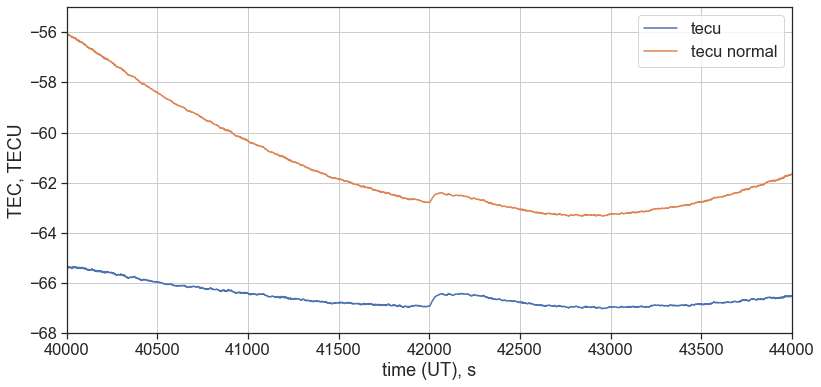

In [20]:
plt.figure(figsize=(13, 6))

plt.plot(time, tecu, label='tecu')
plt.plot(time, tecu_normal, label='tecu normal')

plt.xlabel('time (UT), s')
plt.ylabel('TEC, TECU')
plt.xlim(t_start+1000, t_end+1000)
plt.ylim(-68, -55)
plt.legend()
plt.grid()

#### Детрендирование

Для выполнения расчетов участок, относящийся ко вспышке будет вырезан, после чего будет произведена интерполяция

In [21]:
t_an_start = 42000
t_an_end = 42600

In [22]:
indexes = np.where(((time<=t_an_start) & (time>=t_start)) | ((time<=t_end) & (time>=t_an_end)))[0]
y2 = tecu_normal[indexes]
y2.shape

(3402,)

In [23]:
t2 = time[indexes]
t2.shape

(3402,)

In [24]:
from scipy.interpolate import interp1d

In [25]:
f = interp1d(t2, y2)

ti = np.arange(t_start, t_end)
interpolation_values = f(ti)

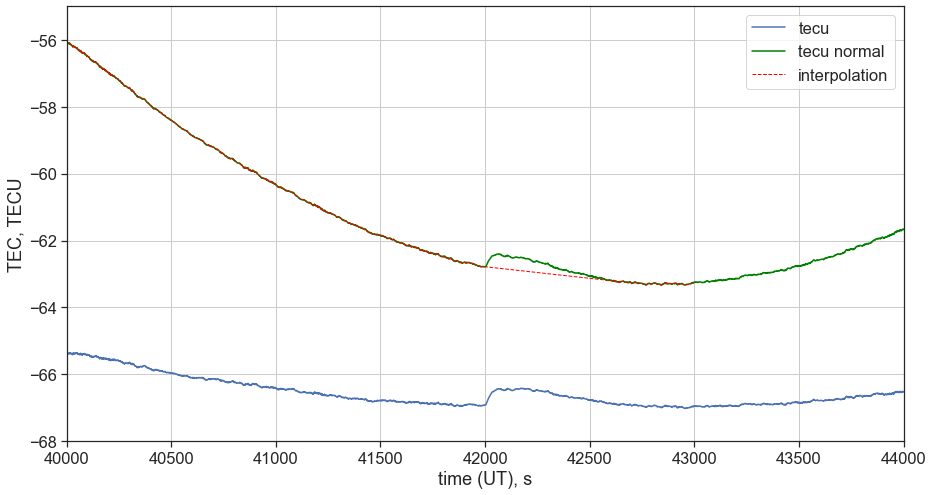

In [26]:
plt.figure(figsize=(15, 8))

plt.plot(time, tecu, label='tecu')
plt.plot(time, tecu_normal, label='tecu normal', color='green')
plt.plot(ti, interpolation_values, linestyle='--', linewidth=1, label='interpolation', color='red')

plt.xlim(t_start+1000, t_end+1000)
plt.ylim(-68, -55)
plt.xlabel('time (UT), s')
plt.ylabel('TEC, TECU')
plt.legend()
plt.grid()

$\Delta$ **TEC**

Вычитая из исходных данных данные, полученные после интерполяции, получим график приращения ПЭС во время солнечной вспышки, произошедшей 10 июня 2014 года, от времени

In [27]:
indxs = np.where((time<=t_end) & (time>=t_start))[0]
y4 = tecu_normal[indxs]
y4.shape

n = len(ti)
difference = np.zeros(n)

for i in range(n):
    difference[i] = y4[i] - interpolation_values[i]

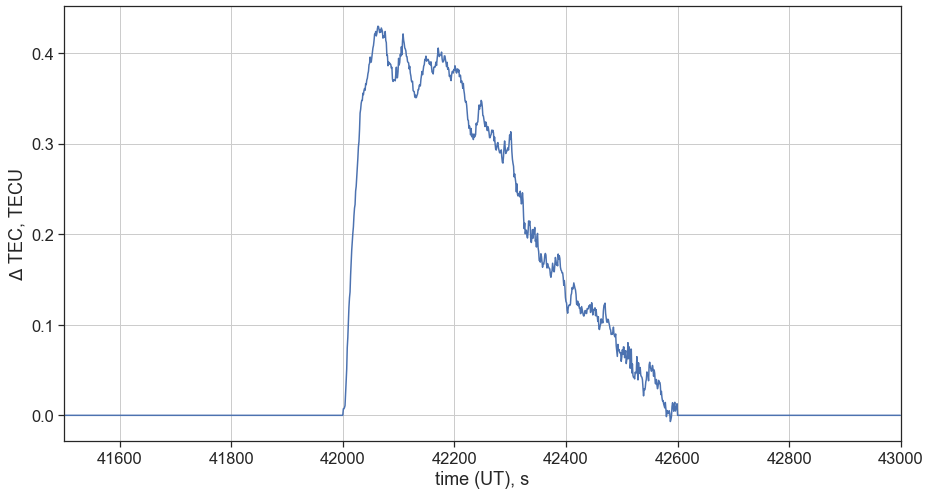

In [28]:
plt.figure(figsize=(15, 8))

plt.plot(ti, difference)
plt.xlabel('time (UT), s')
plt.ylabel(r'$\Delta$ TEC, TECU')
         
plt.xlim(41500, 43000)
plt.grid()

### Измерения для всех спутников

In [29]:
from phase_measurements import satellite_calculations

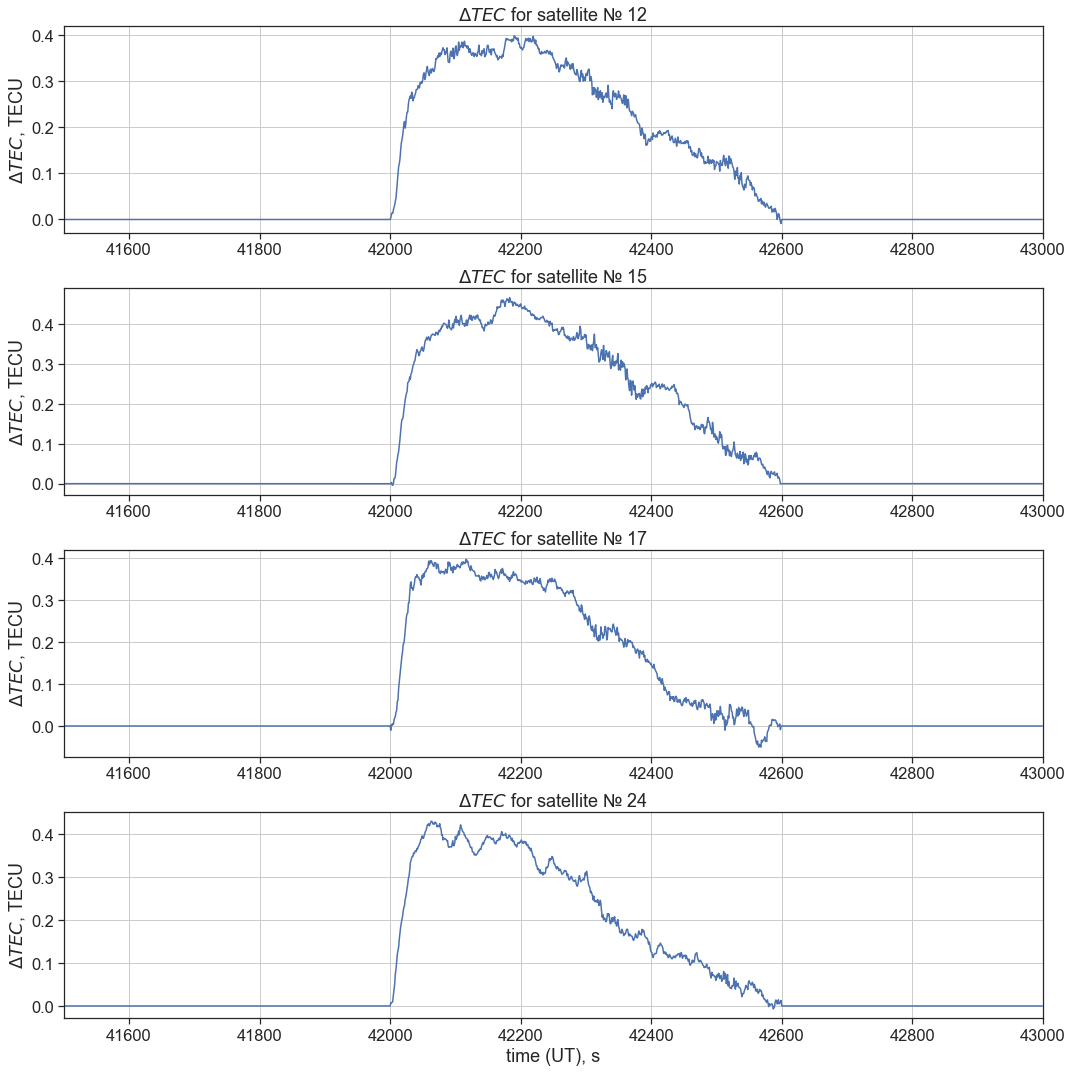

In [30]:
sat_numbers = [12, 15, 17, 24]  # номера активных в данный период спутников

other_params = [t_start, t_end, t_an_start, t_an_end, m, TECU_normal]

plt.figure(figsize=(15, 15))

results = []

for i in range(4):
    
    x, y = satellite_calculations(sat_numbers[i], other_params)
    results.append(y)

    plt.subplot(4, 1, i+1)  
    plt.plot(x, y)
    plt.xlim(41500, 43000)
    plt.title(r'$\Delta TEC$ for satellite № ' + f'{sat_numbers[i]}')
    plt.ylabel(r'$\Delta TEC$, TECU')
    if i == len(sat_numbers) - 1:
        plt.xlabel('time (UT), s')
    plt.grid()

plt.tight_layout()
results = np.array(results)

**Среднее приращение ПЭС для всех спутников**

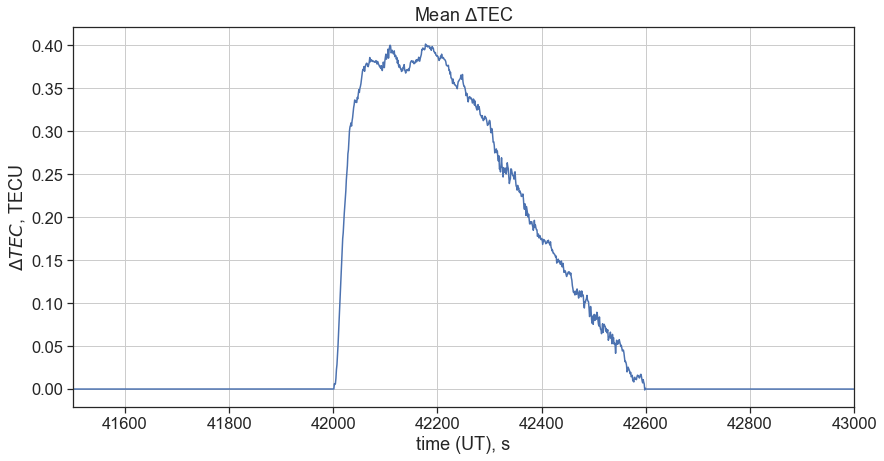

In [31]:
mean_delta_tec = np.sum(results, axis=0) / 4

plt.figure(figsize=(14, 7))
plt.plot(ti, mean_delta_tec)
plt.xlim(41500, 43000)
plt.title(r'Mean $\Delta$TEC')
plt.ylabel(r'$\Delta TEC$, TECU')
plt.xlabel('time (UT), s')
plt.grid()

## Поток рентгеновского излучения во время вспышки 10.06.2014

Данные о потоке рентгеновского излучения получены со спутника GOES

https://satdat.ngdc.noaa.gov/sem/goes/data/full/2014/06/goes15/netcdf/

In [32]:
directory = './data_xray_2014'
filename = '/g15_xrs_2s_20140610_20140610.nc'

xray_data = netcdf.NetCDFFile(directory+filename, 'r')

In [33]:
bf = xray_data.variables['B_FLUX'][:]
t = xray_data.variables['time_tag'][:]

In [34]:
t_1 = (t - np.min(t)) / 1000
t_start2 = 41500
t_end2 = 43000

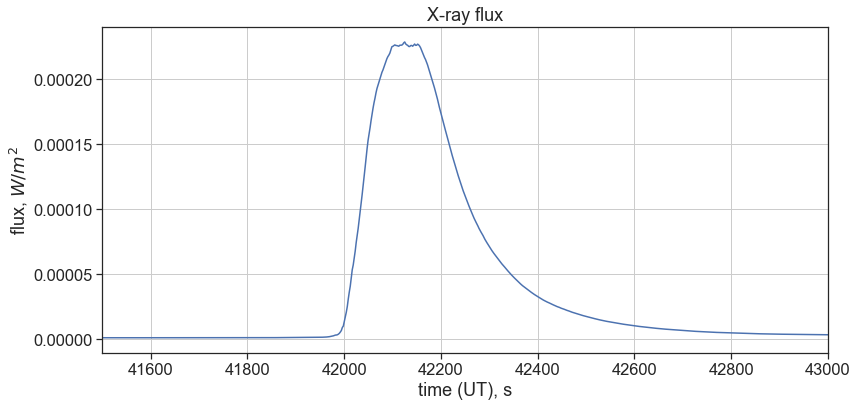

In [35]:
plt.figure(figsize=(13, 6))

plt.plot(t_1, bf)
plt.xlim(t_start2, t_end2)
plt.xlabel('time (UT), s')
plt.ylabel(r'flux, $W/m^2$')
plt.title('X-ray flux')

plt.grid()

**Сопоставление приращения ПЭС c потоком рентгена**

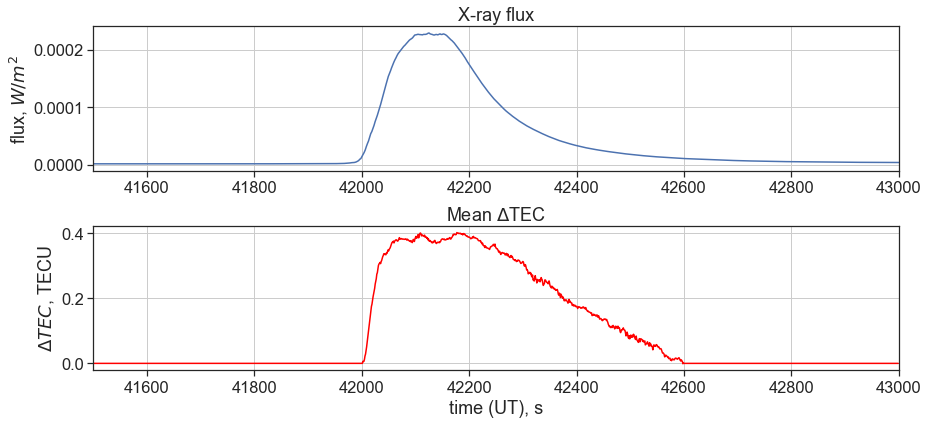

In [36]:
plt.figure(figsize=(13, 6))

plt.subplot(2, 1, 1)
plt.plot(t_1, bf)
plt.xlim(t_start2, t_end2)
plt.ylabel(r'flux, $W/m^2$')
plt.title('X-ray flux')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(ti, mean_delta_tec, color='red')
plt.xlim(41500, 43000)
plt.title(r'Mean $\Delta$TEC')
plt.ylabel(r'$\Delta TEC$, TECU')
plt.xlabel('time (UT), s')
plt.grid()

plt.tight_layout()

## Высотные профили нейтралов

Для определения концентрации электронов была рассмотрена четырехкомпонентная плазмохимическая модель. По этой модели построена система дифференциальных уравнений, из решения которой и определялась электронная концентрация.

В качестве входных данных этой плазмохимической модели использовались данные, полученные со спутника AURA: высотные профили давления и концентраций нейтралов за 2004-2018 года.


In [38]:
path_2 = './data_height_profiles/'
filename = '/data.mat'

data_2 = loadmat(path_2 + filename)

In [39]:
conditions = pd.DataFrame(data_2['Conditions'])
conditions

,0,1,2,3,4,5,6,7,8,9
0,2004.0,8.0,3.0,7.0,56.0,17.809053,83.743843,20.289310,NaN,3.0
1,2004.0,8.0,3.0,15.0,12.0,8.906730,158.529861,143.843002,NaN,0.0
2,2004.0,8.0,3.0,16.0,53.0,2.969144,132.584564,148.586533,NaN,0.0
3,2004.0,8.0,3.0,19.0,28.0,23.738419,-90.297546,20.093258,NaN,0.0
4,2004.0,8.0,3.0,20.0,4.0,25.219446,88.214554,129.637878,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...
95662,2017.0,1.0,1.0,18.0,20.0,-28.180552,-64.717110,27.035311,70.3,7.0
95663,2017.0,1.0,1.0,18.0,21.0,-26.700346,-65.114517,26.715939,70.3,7.0
95664,2017.0,1.0,1.0,19.0,16.0,4.453685,97.445908,149.079193,70.3,7.0
95665,2017.0,1.0,1.0,23.0,44.0,68.899780,-171.957016,91.867645,70.3,6.0


In [40]:
data_2['description']

array([[array(['Conditions:'], dtype='<U11')],
       [array(['1 столбец - год'], dtype='<U15')],
       [array(['2 столбец - месяц'], dtype='<U17')],
       [array(['3 столбец - день'], dtype='<U16')],
       [array(['4 столбец - час'], dtype='<U15')],
       [array(['5 столбец - минута'], dtype='<U18')],
       [array(['6 столбец - широта'], dtype='<U18')],
       [array(['7 столбец - долгота'], dtype='<U19')],
       [array(['8 столбец - SZA'], dtype='<U15')],
       [array(['9 столбец - индекс F10.7'], dtype='<U24')],
       [array(['10 столбец - индекс Ap'], dtype='<U22')],
       [array(['-'], dtype='<U1')],
       [array(['Temperature:'], dtype='<U12')],
       [array(['Высотный профиль температуры с 50 до 90 км с шагом 5 км, [К]'],
      dtype='<U60')],
       [array(['-'], dtype='<U1')],
       [array(['Pressure:'], dtype='<U9')],
       [array(['Высотный профиль давления с 50 до 90 км с шагом 5 км, [Па]'],
      dtype='<U58')]], dtype=object)

Для определения среднего электронного содержания в D-области, произведем отбор данных по следующим критериям:

    1) период солнечной активности (месяц)
    2) зенитный угол (от 0 до 60 градусов)
    3) индекс F10.7 > 150

In [41]:
from height_profile_measurements import height_profile

In [42]:
P_mean, T_mean = height_profile(data_2, months_nums=[6, 7])

In [43]:
# расчет концентраций нейтралов
k = 1.38e-23
M = (P_mean / (k * T_mean)) * 1e-6

M_N2 = 0.78084 * M
M_O2 = 0.20946 * M

h = np.arange(50, 95, 5)

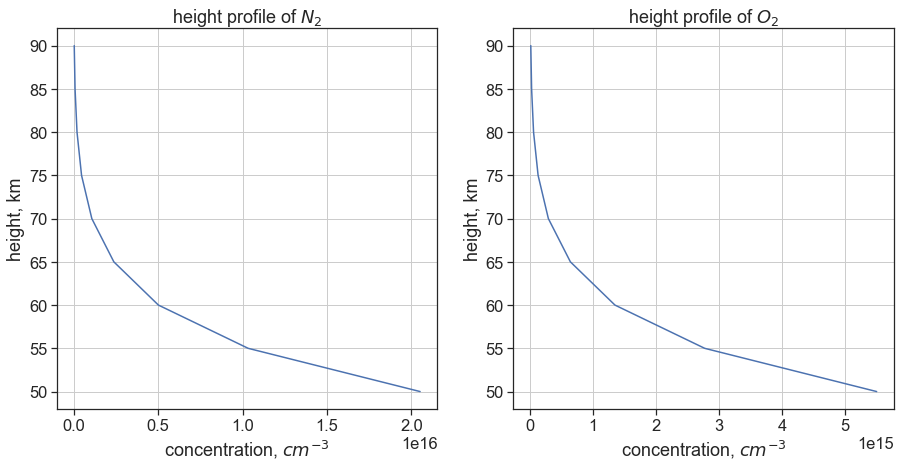

In [44]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(M_N2, h)

plt.title(r'height profile of $N_2$')
plt.xlabel(r'concentration, $cm^{-3}$')
plt.ylabel('height, km')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(M_O2, h)

plt.title(r'height profile of $O_2$')
plt.xlabel(r'concentration, $cm^{-3}$')
plt.ylabel('height, km')
plt.grid()

In [45]:
results = np.vstack((P_mean, T_mean, M_N2, M_O2))

cols = ['h = 50 km', 'h = 55 km', 'h = 60 km', 'h = 65 km', 'h = 70 km', 'h = 75 km', 'h = 80 km', 'h = 85 km', 'h = 90 km']
rows = ['P, Pa', 'T, K', 'N_N2, cm^-3', 'N_O2, cm^-3']

pd.DataFrame(results, index=rows, columns=cols)

,h = 50 km,h = 55 km,h = 60 km,h = 65 km,h = 70 km,h = 75 km,h = 80 km,h = 85 km,h = 90 km
"P, Pa",8.831818e+01,4.571539e+01,2.287474e+01,1.101098e+01,4.984580e+00,2.141381e+00,8.795428e-01,3.438205e-01,1.282474e-01
"T, K",2.435705e+02,2.504021e+02,2.580694e+02,2.623576e+02,2.633632e+02,2.618389e+02,2.566173e+02,2.494227e+02,2.430719e+02
"N_N2, cm^-3",2.051675e+16,1.033017e+16,5.015366e+15,2.374735e+15,1.070919e+15,4.627460e+14,1.939340e+14,7.799713e+13,2.985360e+13
"N_O2, cm^-3",5.503608e+15,2.771064e+15,1.345370e+15,6.370218e+14,2.872735e+14,1.241314e+14,5.202272e+13,2.092270e+13,8.008216e+12


По этим результатам были рассчитаны высотные профили концентраций электронов

### TEC в D-области 

In [46]:
path = './data_electron_concentrations_2014/'
filename = '/Ne4_55_38_10062014_ad2.55_1.0.mat'

data_3 = loadmat(path + filename)

In [47]:
O_2 = data_3['O2']
Ne = data_3['Ne_4']
pd.DataFrame(Ne)

,0,1,2,3,4,5,6,7,8
0,14.534150,17.056167,19.480509,21.959620,48.778348,169.779842,515.973598,3918.769144,21173.103403
1,14.534190,17.056249,19.480616,21.959943,48.791523,170.110359,516.434018,3920.227680,21293.089333
2,14.534229,17.056332,19.480750,21.960682,48.827835,170.440908,517.534027,3925.503243,21312.414847
3,14.534270,17.056429,19.480989,21.962399,48.882617,170.850605,519.218551,3935.005385,21296.970660
4,14.534314,17.056556,19.481486,21.966420,48.968008,171.471869,523.451077,3965.688629,21366.189611
...,...,...,...,...,...,...,...,...,...
716,14.534876,17.054589,19.444706,21.380757,22.935215,31.219572,84.285508,407.749151,2484.590839
717,14.534878,17.054593,19.444885,21.383005,22.965413,32.825169,116.575972,642.971806,3185.020529
718,14.534879,17.054597,19.445061,21.385167,22.993853,34.280943,142.674427,853.503002,3824.390659
719,14.534880,17.054599,19.445217,21.387086,23.019726,35.635785,164.131026,1039.469072,4392.292629


In [48]:
hours = O_2[:, 0]
minutes = O_2[:, 1]

t = (hours * 3600) + (minutes * 60)

Считаем TEC по определению - интегрируем $N_e$

In [49]:
n = len(t)
tec = np.zeros(n)

for i in range(n):
    s = 0
    for j in range(8):
        s += ((Ne[i, j] + Ne[i, j+1]) / 2) * 5000 * 1e6
    tec[i] = s

tecu = tec * 1e-16

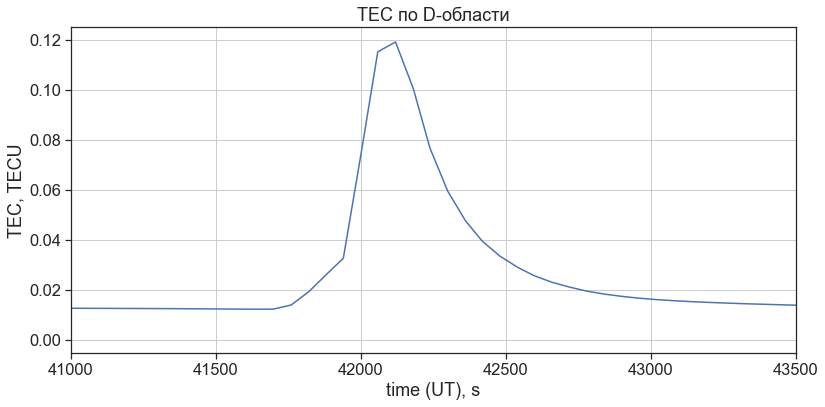

In [50]:
plt.figure(figsize=(13, 6))

plt.plot(t, tecu)
plt.xlabel('time (UT), s')
plt.ylabel('TEC, TECU')
plt.xlim(t_start+2000, t_end+500)
plt.title('TEC по D-области')
plt.grid()

## Результаты

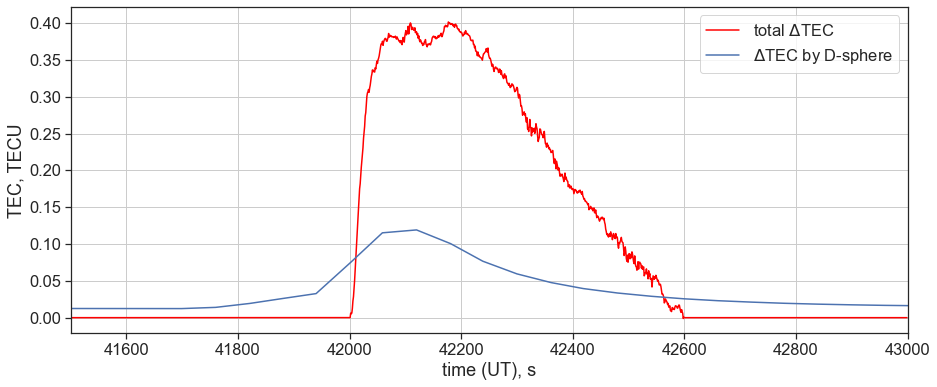

In [51]:
plt.figure(figsize=(15, 6))

plt.plot(ti, mean_delta_tec, color='red', label=r'total $\Delta$TEC')
plt.plot(t, tecu, label=r'$\Delta$TEC by D-sphere')

plt.xlim(t_start+2500, t_end)
plt.xlabel('time (UT), s')
plt.ylabel('TEC, TECU')
plt.legend()
plt.grid()

Построим этот же график в относительных величинах для наглядности

In [52]:
maximum = np.nanmax(mean_delta_tec)
mean_delta_tec_1 = mean_delta_tec / maximum
tecu_1 = tecu / maximum

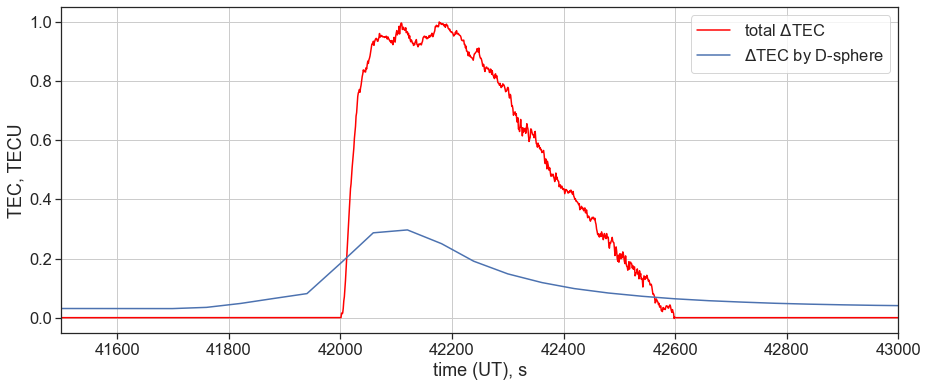

In [53]:
plt.figure(figsize=(15, 6))

plt.plot(ti, mean_delta_tec_1, color='red', label=r'total $\Delta$TEC')
plt.plot(t, tecu_1, label=r'$\Delta$TEC by D-sphere')

plt.xlim(t_start+2500, t_end)
plt.xlabel('time (UT), s')
plt.ylabel('TEC, TECU')
plt.legend()
plt.grid()

**Итог:** для вспышки 10.06.2014 вклад D-области в полное электронное содержание составил 27% в пике потока рентгеновского излучения